In [5]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\Zahra\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

In [6]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
import warnings
from IPython.display import clear_output
from IPython import display
from PIL import Image, ImageStat
from io import BytesIO
import time
import random
import math
random.seed(11)

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [7]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

tableau10 = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

In [8]:
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau10)):  
    r, g, b = tableau10[i]  
    tableau10[i] = (r / 255., g / 255., b / 255.)

In [9]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
#plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
#LOAD DATA

# load airbnb - For now use New York Data as it is more openly available

df = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\data\raw\new york\listings.csv')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 39.5+ MB


In [15]:
# load Urban Environment Surroundings Data

noise = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\data\raw\new york\311_noise_complaints.csv')
sub = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\data\raw\DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv')
groc = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\data\raw\Retail_Food_Stores.csv')

noise.info()
sub.info()
groc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118622 entries, 0 to 118621
Data columns (total 39 columns):
Unique Key                        118622 non-null int64
Created Date                      118622 non-null object
Closed Date                       118135 non-null object
Agency                            118622 non-null object
Agency Name                       118622 non-null object
Complaint Type                    118622 non-null object
Descriptor                        118622 non-null object
Location Type                     109699 non-null object
Incident Zip                      118471 non-null float64
Incident Address                  112102 non-null object
Street Name                       112102 non-null object
Cross Street 1                    111868 non-null object
Cross Street 2                    111793 non-null object
Intersection Street 1             16420 non-null object
Intersection Street 2             16375 non-null object
Address Type                      10

In [49]:
def noLongerAvail(url):
    """ 
    Flag listings that are no longer available on airbnb. 
  
    Parameters: 
    url: URL of the listing
  
    Returns: 
    1 if listing not available, 0 otherwise.
    """
    page = requests.post(url)
    soup = BeautifulSoup(page.content, "html.parser")
    if soup.title.string == 'Vacation Rentals, Homes, Experiences & Places - Airbnb':
        return 1
    else:
        return 0
    
df['flag_noLongerAvail'] = df.listing_url.apply(noLongerAvail)

print ('Ratio of no longer available listings over total:', df.flag_noLongerAvail.sum()/float(len(df))

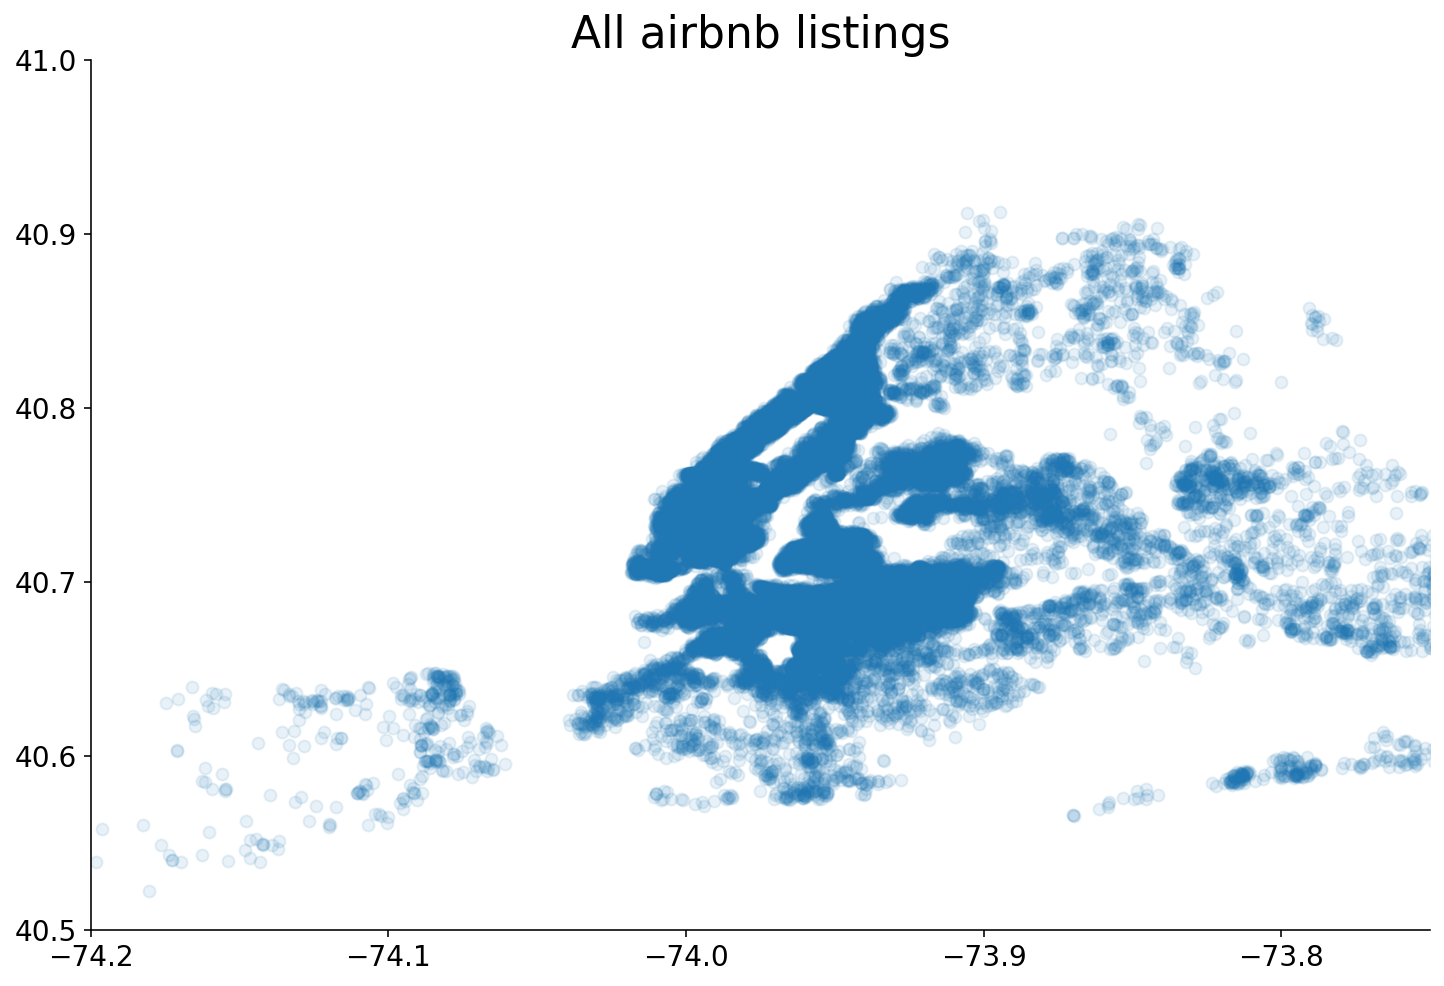

In [53]:
# Visualize the airbnb listings

plt.scatter(df.longitude, df.latitude, alpha=.1)
plt.title('All airbnb listings')
plt.ylim(40.5,41)
plt.xlim(-74.2, -73.75)
plt.show()

In [57]:
# AIRBNB LISTINGS

# Convert lat/lon to shapely point
df['Coordinates'] = list(zip(df.longitude, df.latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)

# Convert coordinates
dfGeo = gpd.GeoDataFrame(df, crs={'init' :'epsg:4326'}, geometry='Coordinates')

# Create the 1/4 mile buffer
count=0
buffers = []
start = time.time()

for point in dfGeo.Coordinates:
    try:
        buffers.append(point.buffer(402.3/111320.0)) #402.3 meters
    except:
        buffers.append(np.nan)
    
    count += 1
    if count in np.arange(0,49000,100):
        clear_output()
        print ('Completed %s evaluations'%count)

dfGeo['buffer_quarterMile'] = buffers

print ('It took', time.time()-start, 'seconds.')

Completed 48800 evaluations
It took 5.532817363739014 seconds.


In [58]:
# 311 NOISE COMPAINTS

# convert to shapely points
noise['Coordinates'] = list(zip(noise.Longitude, noise.Latitude))
noise['Coordinates'] = noise['Coordinates'].apply(Point)

In [53]:
# GROCERY STORES LOCATED IN NYC

# filter grocery stores located in NYC
nycCounties = ['New York', 'Kings', 'Richmond', 'Bronx', 'Queens']
groc = groc[groc.County.isin(nycCounties)]
print(groc.shape)

# flag the ones where location is missing
groc['flag_MissingLocation'] = groc.Location.apply(lambda x: 0 if x==x else 1)
groc = groc[groc.flag_MissingLocation==0]
print (groc.shape)

# clean address information and bring to right format for geocoding
groc['Street Number'] = groc['Street Number'].apply(lambda x:str(x))
groc['Street Name'] = groc['Street Name'].apply(lambda x:str(x))
groc['Zip Code'] = groc['Zip Code'].apply(lambda x:str(x))
groc['Address'] = groc['Street Number'] + groc['Street Name'] + ',' + groc['City'] + groc['State'] + groc['Zip Code']

def cleanAddress(x):
    """ 
    Converts address to its proper format for geocoding
  
    Parameters: 
    x: dataframe including street name, number, state and zip code
  
    Returns: 
    address: address string ready for geocoding
  
    """
    
    streetNum = x['Street Number'].rstrip()
    streetName = x['Street Name'].rstrip()
    city = x['City'].rstrip()
    state = x['State'].rstrip()
    zipCode = x['Zip Code'].rstrip()
    return streetNum + ' ' + streetName + ' ' + city + ' ' + state + ' ' + zipCode

groc['Address'] = groc.apply(cleanAddress, axis=1)

(14199, 17)
(14199, 17)


In [ ]:
start = time.time()

# initialize geocoder
geolocator = Nominatim()
#set min_delay to 1sec so the API doesn't block you
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=10)
# geocode address
groc['location'] = groc['Address'].apply(geocode)
groc['point'] = groc['location'].apply(lambda loc: tuple(loc.point) if loc else None)

print ('It took', time.time()-start, 'seconds.')
#convert to shapely points
groc['Coordinates'] = list(zip(groc.lon, groc.lat))
groc['Coordinates'] = groc['Coordinates'].apply(Point)

groc = groc[groc.point==groc.point]
groc.shape